# OLMAR portfolio in zipline-trader with csv data

## Using zipline-trader with csv file data
You can use csv file data with 'csvdir' bundle, which is originally registered.  
I explain it for Jupyter notebook use.
```
There are several explainations about using csv files.  
Original zipline documents has an example of a custom data bundle using csv files.  
But it's not working. In my case, it makes an error not knowing Key of data.  
```

## procedures
1. prepare csv data with format of OHLCV(open, high, low, close, volume) format.  
  You can add dividends and split optionally. 
2. set zipline environment like bundle location
3. ingest csv data into bundles
4. load bundle data into memory
5. apply trading strategy

## references
I used codes for universal portfolio and zipline example codes from  
https://github.com/andrewcharlesjones/universal_portfolios/blob/master/universal_portfolio.ipynb  
https://github.com/shlomikushchi/zipline-trader/blob/master/zipline/examples/olmar.py
    

zipline 에들어가는 기본 data format 은 OHLCV(open, high, low, close, volume) 형태이다.  
추가적으로 dividend와 split 이 가능하다.
```
date,open,high,low,close,volume,dividend,split
2012-01-03,58.485714,58.92857,58.42857,58.747143,75555200,0.0,1.0
2012-01-04,58.57143,59.240002,58.468571,59.062859,65005500,0.0,1.0
2012-01-05,59.278572,59.792858,58.952858,59.718571,67817400,0.0,1.0
2012-01-06,59.967144,60.392857,59.888573,60.342857,79573200,0.0,1.0
2012-01-09,60.785713,61.107143,60.192856,60.247143,98506100,0.0,1.0
2012-01-10,60.844284,60.857143,60.214287,60.462856,64549100,0.0,1.0
2012-01-11,60.382858,60.407143,59.901428,60.364285,53771200,0.0,1.0
```

## 1. Change DATA format

In [71]:
# copy file into csv folder
# remove adjacent-close from original yahoo format
files = ['AMD.csv', 'CERN.csv', 'COST.csv', 'DELL.csv', 'GPS.csv', 'INTC.csv', 'MMM.csv'] 
col_names = ['date','open','high','low','close', '--', 'volume']
usecols = ['date', 'open', 'high', 'low', 'close', 'volume']

In [81]:
for f_s in files:
    df1 = pd.read_csv('original_csv/'+f_s, names=col_names, usecols=usecols, header=0)
    df1 = df1.fillna(method='ffill')
    df1['dividend'] = 0
    df1['split'] = 1.0
    df1.to_csv('csv/daily/'+f_s, index=False, float_format='%.6f')

## 2. set environment
* file location should be in os environment variable 'CSVDIR'
* zipline location should be in ZIPLINE_ROOT
* If you need some configuration, edit ZIPLINE_TRADER_CONFIG
* file names are used as data symbol name

In [4]:
import os
import pandas as pd

#home_zipline = os.getcwd()
home_zipline = 'YOUR PATH'
os.environ['ZIPLINE_ROOT'] = os.path.join(home_zipline, '.zipline')
os.environ['ZIPLINE_TRADER_CONFIG'] = os.path.join(home_zipline, 
                                                   ".zipline/zipline-trader.yaml")
os.environ['CSVDIR'] = 'CSV FILE PATH'

In [7]:
import zipline
from zipline.data import bundles
from zipline.data.bundles import ingest, load, register

In [16]:
#import zipline.data.bundles.csvdir

## 3. ingesting
* You need ingesting only at the first time for each data

In [8]:
bundle_name = 'csvdir'
assets_version = ((),)[0]
ingest(bundle_name, os.environ, 
       assets_versions=assets_version,
       show_progress=True)

 | AMD: sid 0
 | CERN: sid 1
 | COST: sid 2
 | DELL: sid 3
 | GPS: sid 4
 | INTC: sid 5
 | MMM: sid 6


## 4. Loading
* You need loading every time to run code (it puts data into memory)

In [9]:
bundle_data = bundles.load(bundle_name)

### Example. check loaded data

In [37]:
# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = start_date,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

In [39]:
equity = bundle_data.asset_finder.lookup_symbol("DELL", end_date)
print(equity, type(equity))
data_portal.get_history_window(assets=[equity], end_dt=end_date, 
                                bar_count=10,
                               frequency='1d',
                               field='close',
                               data_frequency='daily')

Equity(3 [DELL]) <class 'zipline.assets._assets.Equity'>


,Equity(3 [DELL])
2021-02-16 00:00:00+00:00,79.44
2021-02-17 00:00:00+00:00,79.26
2021-02-18 00:00:00+00:00,79.69
2021-02-19 00:00:00+00:00,80.77
2021-02-22 00:00:00+00:00,80.77
2021-02-23 00:00:00+00:00,80.56
2021-02-24 00:00:00+00:00,81.69
2021-02-25 00:00:00+00:00,79.68
2021-02-26 00:00:00+00:00,81.07
2021-03-01 00:00:00+00:00,83.09


## 5.Trading(or Portfolio) strategy

In [36]:
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.data.data_portal import DataPortal

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# time should be a business datetime
start_date = pd.Timestamp('2016-09-20', tz='utc')
end_date = pd.Timestamp('2021-03-01', tz='utc')

In [15]:
import sys
import logbook
import numpy as np
import matplotlib.pyplot as plt

from zipline.finance import commission, slippage
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm

Reading data from CSV  
https://zipline-trader.readthedocs.io/en/latest/bundles.html#ingesting-data-from-csv-files  
Original zipline uses command line binaries.  
Instead of it, here I modified codes to run in notebook or python script.

### Define Portfolio strategy OLMAR
from https://github.com/shlomikushchi/zipline-trader/blob/master/zipline/examples/olmar.py
* initialize is used for preparation setting
* handle_data indicates behaviors at each time period

In [45]:
# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    #print(algo.symbol('0'))
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    #algo.sids = STOCKS
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0, min_trade_cost=1.0))
    algo.set_slippage(slippage.VolumeShareSlippage())


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)

    # find relative moving average price for each asset
    
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")
        #print('prices', prices[i])

    desired_amount = np.round(desired_port * positions_value / prices)
    #print('desired_amount', desired_amount, 'port', desired_port)
    
    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    r"""Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> proj  # doctest: +NORMALIZE_WHITESPACE
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111)
    results.portfolio_value.plot(ax=ax)
    ax.set_ylabel('Portfolio value (USD)')
    plt.show()

In [18]:
import pandas_datareader.data as yahoo_reader
def get_benchmark(symbol=None, start=None, end=None):
    bm = yahoo_reader.DataReader(symbol,
                                 'yahoo',
                                 pd.Timestamp(start),
                                 pd.Timestamp(end))['Close']
    bm.index = bm.index.tz_localize('UTC')
    return bm.pct_change(periods=1).fillna(0)

def before_trading_start(context, data):
    pass

### Prepare benchmark : S&P500 data

In [41]:
benchmark = get_benchmark(symbol="SPY",
                          start=start_date.date().isoformat(),
                          end=end_date.date().isoformat())

In [42]:
benchmark

Date
2016-09-19 00:00:00+00:00    0.000000
2016-09-20 00:00:00+00:00    0.000047
2016-09-21 00:00:00+00:00    0.011245
2016-09-22 00:00:00+00:00    0.006301
2016-09-23 00:00:00+00:00   -0.005479
                               ...   
2021-02-23 00:00:00+00:00    0.001214
2021-02-24 00:00:00+00:00    0.011019
2021-02-25 00:00:00+00:00   -0.024096
2021-02-26 00:00:00+00:00   -0.005153
2021-03-01 00:00:00+00:00    0.024240
Name: Close, Length: 1119, dtype: float64

### Run model

.local/lib/python3.6/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
.local/lib/python3.6/site-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,


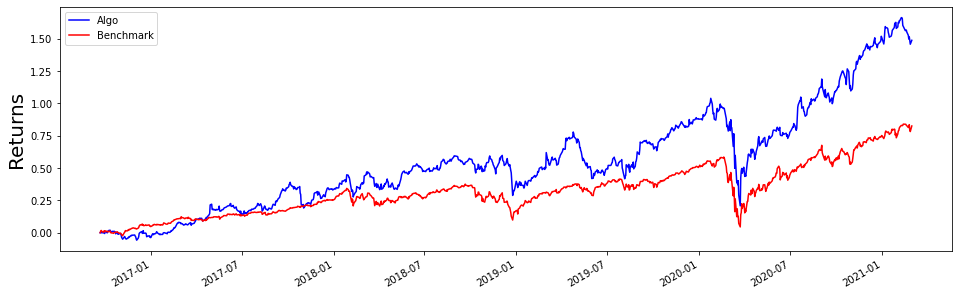

In [81]:
trading_calendar = get_calendar('NYSE')
STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']
#STOCKS = ['0', '1', '2', '3', '4', '5', '6']
#STOCKS = [0, 1, 2, 3, 4, 5, 6]

r = run_algorithm(start=start_date,
                      end=end_date,
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      benchmark_returns=benchmark,
                      bundle=bundle_name,
                      broker=None,
                      state_filename="./demo.state",
                      trading_calendar=trading_calendar,
                      before_trading_start=before_trading_start,
                      #                   analyze=analyze,
                      data_frequency='daily'
                      )
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
r.algorithm_period_return.plot(color='blue')
r.benchmark_period_return.plot(color='red')


plt.legend(['Algo', 'Benchmark'])
plt.ylabel("Returns", color='black', size=20)
plt.show()

### Result of running

In [77]:
r

,period_open,period_close,long_exposure,ending_cash,returns,orders,ending_value,starting_value,capital_used,short_exposure,...,treasury_period_return,trading_days,sharpe,sortino,excess_return,alpha,beta,max_leverage,period_label,max_drawdown
2016-09-20 20:00:00+00:00,2016-09-20 13:31:00+00:00,2016-09-20 20:00:00+00:00,0.00,100000.000000,0.000000,[],0.00,0.00,0.00,0.0,...,0.0,1,NaN,NaN,0.0,NaN,NaN,0.00000,2016-09,0.000000
2016-09-21 20:00:00+00:00,2016-09-21 13:31:00+00:00,2016-09-21 20:00:00+00:00,0.00,100000.000000,0.000000,[],0.00,0.00,0.00,0.0,...,0.0,2,NaN,NaN,0.0,0.000000,0.000000,0.00000,2016-09,0.000000
2016-09-22 20:00:00+00:00,2016-09-22 13:31:00+00:00,2016-09-22 20:00:00+00:00,0.00,100000.000000,0.000000,[],0.00,0.00,0.00,0.0,...,0.0,3,NaN,NaN,0.0,0.000000,0.000000,0.00000,2016-09,0.000000
2016-09-23 20:00:00+00:00,2016-09-23 13:31:00+00:00,2016-09-23 20:00:00+00:00,0.00,100000.000000,0.000000,[],0.00,0.00,0.00,0.0,...,0.0,4,NaN,NaN,0.0,0.000000,0.000000,0.00000,2016-09,0.000000
2016-09-26 20:00:00+00:00,2016-09-26 13:31:00+00:00,2016-09-26 20:00:00+00:00,0.00,100000.000000,0.000000,"[{'id': '8baad25625f54ed988949d0487f01faf', 'd...",0.00,0.00,0.00,0.0,...,0.0,5,NaN,NaN,0.0,0.000000,0.000000,0.00000,2016-09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-23 21:00:00+00:00,2021-02-23 14:31:00+00:00,2021-02-23 21:00:00+00:00,249798.52,-20.116748,-0.011529,"[{'id': '79eb423e374949529b813140e3fd5d96', 'd...",249798.52,252717.05,5.35,0.0,...,0.0,1114,0.933426,1.332619,0.0,0.091774,0.990216,1.02553,2021-02,-0.407908
2021-02-24 21:00:00+00:00,2021-02-24 14:31:00+00:00,2021-02-24 21:00:00+00:00,251335.75,95.443252,0.006617,"[{'id': '629bd2dd09d445ac9dd85d310be3eae6', 'd...",251335.75,249798.52,115.56,0.0,...,0.0,1115,0.938768,1.340318,0.0,0.090679,0.989927,1.02553,2021-02,-0.407908
2021-02-25 21:00:00+00:00,2021-02-25 14:31:00+00:00,2021-02-25 21:00:00+00:00,248303.01,102.663252,-0.012033,"[{'id': 'bdcd8f6a77f849c2ae8a901773a76dc6', 'd...",248303.01,251335.75,7.22,0.0,...,0.0,1116,0.927518,1.323969,0.0,0.093786,0.988237,1.02553,2021-02,-0.407908
2021-02-26 21:00:00+00:00,2021-02-26 14:31:00+00:00,2021-02-26 21:00:00+00:00,245681.01,97.403252,-0.010576,"[{'id': 'ed3e5dc5e1734743b3b3fdbbff273fbf', 'd...",245681.01,248303.01,-5.26,0.0,...,0.0,1117,0.917617,1.309625,0.0,0.092314,0.988437,1.02553,2021-02,-0.407908
